# Obligatory assignment 2, MEK4250 :- Trym Erik Nielsen

## Navier Stokes and the Kármán vortex street  

In this assignment we will look at the stability of the Chorin projection scheme in the solution of the Navier Stokes equations.

The navier stokes equations can be expressed as: 
$$ \frac{\partial \rho}{\partial t} + \nabla \cdot(\rho\overrightarrow{u})=0 $$

$$\frac{\partial(\rho \overrightarrow{u})}{\partial t} + \rho (u \cdot \nabla)u = -\overrightarrow{\nabla p} + \overrightarrow{\nabla}\cdot \tau + \rho\overrightarrow{f}$$

We will attempt to solve the Navier stokes equations for flow around a cylinder. This flow domain becomes turbulent at quite low reynolds numbers. With a good selection of initial conditions at the flow inlet and a well resolver mesh, we will be able to see the oscillations of velocity emerging in the wake of the cylinder. For more information on the Kármán vortex phenomena, see [here](https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street)

Due to the turbulent nature of this problem, it can be difficult to compare our numerical solution to an analytical solution. One possible solution is to create manufactured solutions to compare our numerical solution to. In this problem we will observe the convergence of the pressure gradient across the cylinder against the number of cells in the mesh.

We begin by importing relevant packages and defining a meshing function..

In [2]:
%matplotlib inline
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt


#Define problem constants
parameters["std_out_all_processes"] = False;

H = 0.41 #meters
D = 0.1 #meters
length = 2.2 #meters
radius = 0.05 #meters

def mesher(ref):
    """ Returns a mesh and number of degrees
        of freedom for cylinder embedded in
        a 2D channel, ref variable allows for mesh refinement to be
        set.
    """
    rectangle = Rectangle(Point(0,0), Point(length,H))
    circle = Circle(Point(0.15 + D/2,0.15 + D/2), radius)
    domain = rectangle - circle
    mesh = generate_mesh(domain, ref)
    return len(mesh.cells()), mesh

*We can now print an example mesh, notice how the circular shape of the cylinder requires a large number of cells to resolve correctly*

0.0402780360308


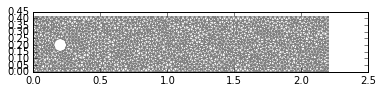

In [3]:
dof, mesh = mesher(ref=50)
print(mesh.hmax())
plot(mesh);

*We can now define a solver to iterate over, and the pressure gradient functional. The solver solves three systems of equations, first the tentative guess of the velocity, then the pressure and velocity update. The solver function has flags for saving the solution to .pvd files, and a switch for changing to a pressure driven flow*

In [3]:
def pressure_grad(t, p):
    #grab coordinates in front of and behind cylinder
    x1 = np.array((0.2 - radius - DOLFIN_EPS, 0.2))
    x2 = np.array((0.2 + radius + DOLFIN_EPS, 0.2))
    return p(x1) - p(x2)

def solver(mesh, velocity_initial_cond=True, save=False):
    # Define function spaces (P2-P1)
    V = VectorFunctionSpace(mesh, "Lagrange", 2)
    Q = FunctionSpace(mesh, "Lagrange", 1)

    # Define trial and test functions
    u = TrialFunction(V)
    p = TrialFunction(Q)
    v = TestFunction(V)
    q = TestFunction(Q)

    # Set parameter values
    dt = 0.001
    T = 3
    nu = 0.001

    if velocity_initial_cond:
        #velocity inlet conditions    
        u_in = Expression(('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0'), degree=2)
    else:    
        #Define time-dependent pressure boundary condition
        p_in = Expression("sin(3.0*t)", t=0.0, degree=2)

    # Define boundaries
    inflow   = 'near(x[0], 0)'
    outflow  = 'near(x[0], 2.2)'
    walls    = 'near(x[1], 0) || near(x[1], 0.41)'
    cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'


    if velocity_initial_cond:
        bcu_wall = DirichletBC(V, Constant((0,0)), walls)
        bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
        bcu_inflow = DirichletBC(V, u_in, inflow)
        bcp_outflow = DirichletBC(Q, Constant(0), outflow)

        bcu = [bcu_inflow, bcu_wall, bcu_cylinder]
        bcp = [bcp_outflow]
    
    else:        
        # Define boundary conditions
        noslip  = DirichletBC(V, Constant((0,0)), NoslipBoundary())
        inflow  = DirichletBC(Q, p_in, Inlet())
        outflow = DirichletBC(Q, Constant(0), Outlet())
        bcu = [noslip]
        bcp = [inflow, outflow]

    # Create functions
    u0 = Function(V)
    u1 = Function(V, name='Velocity')
    p1 = Function(Q, name='Pressure')

    # Define coefficients
    k = Constant(dt)
    f = Constant((0, 0))

    # Tentative velocity step
    F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
         nu*inner(grad(u), grad(v))*dx - inner(f, v)*dx
    a1 = lhs(F1)
    L1 = rhs(F1)

    # Pressure update
    a2 = inner(grad(p), grad(q))*dx
    L2 = -(1/k)*div(u1)*q*dx

    # Velocity update
    a3 = inner(u, v)*dx
    L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

    # Assemble matrices
    A1 = assemble(a1)
    A2 = assemble(a2)
    A3 = assemble(a3)

    # Use amg preconditioner if available
    prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

    # Create files for storing solution
    if save:
        ufile = File("results/velocity.pvd")
        pfile = File("results/pressure.pvd")
    
    pressure_gradient = DOLFIN_EPS
    
    # Time-stepping
    t = dt
    while t < T + DOLFIN_EPS:

        # Update pressure boundary condition
        if not velocity_initial_cond:
            p_in.t = t
        
        begin("Computing time step: " + str(t))
        #Compute tentative velocity step
        b1 = assemble(L1)
        [bc.apply(A1, b1) for bc in bcu]
        solve(A1, u1.vector(), b1, "gmres", "default")
        
        #Compute pressure correction
        b2 = assemble(L2)
        [bc.apply(A2, b2) for bc in bcp]
        solve(A2, p1.vector(), b2, "cg", prec)

        #Compute velocity correction
        b3 = assemble(L3)
        [bc.apply(A3, b3) for bc in bcu]
        solve(A3, u1.vector(), b3, "gmres", "default")
        end()
        
        new_P_grad = pressure_grad(t,p1)
        
        if abs(new_P_grad) > pressure_gradient:
            pressure_gradient = new_P_grad
            
        #pressure_gradient.append(pressure_grad(t,p1))
        # Save to file
        if save:
            ufile << u1
            pfile << p1

        # Move to next time step
        u0.assign(u1)
        t += dt
    return pressure_gradient

## Analysis

*We can now solve the Navier Stokes equations using our three defined functions, for a range of mesh refinements. By plotting the cylinder pressure gradient functional against the number of cells in the mesh, we can get some sense of the convergence of the solution, and therefore the stability of Chorin's projection method*

Solving for refinement = 15
Solving for refinement = 25
Solving for refinement = 35
Solving for refinement = 45
Solving for refinement = 55


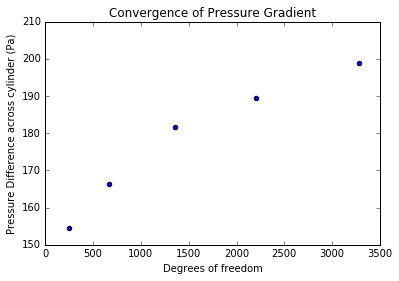

In [5]:
refinements = [15,25,35,45,55] #Number of cells across height of channel, refinments
pressure_gradients = []
dofs = []

for refinement in refinements:
    dof, mesh = mesher(refinement)
    dofs.append(dof)
    print('Solving for refinement = {refinement}'.format(refinement=refinement))
    gradient = solver(mesh, velocity_initial_cond=True, save=False)
    pressure_gradients.append(gradient)

pressure_gradients = np.asarray(pressure_gradients)
dofs = np.asarray(dofs)

plt.scatter(dofs, pressure_gradients)
plt.xlabel('Number of cells')
plt.ylabel('Pressure Difference across cylinder (Pa)')
plt.title('Convergence of Pressure Gradient')
plt.show()

### Developed Vortex

*Below we have included a picture of the paraview postprocessed .pvd velocity file. We can clearly see the vortex shedding develop in the wake of the cylinder. The flow field is captured at approximately 2 seconds of flow*

![Vortex Street](VortexStreet.png)